
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
## library imports here

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import export_graphviz
from IPython.display import display, Image
import graphviz
from sklearn import tree
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from plotnine import *

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1
...,...,...,...,...,...,...,...,...
268,59,1,0,164,176,0,90,0
269,57,0,0,140,241,1,123,0
270,45,1,3,110,264,1,132,0
271,68,1,0,144,193,1,141,0


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [18]:
X = ha.drop('cp', axis = 1)

y = ha['cp']
X

,age,sex,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,145,233,0,150,1,1,0,0,0
1,37,1,130,250,1,187,1,0,1,0,0
2,56,1,120,236,1,178,1,0,0,1,0
3,57,0,120,354,1,163,1,0,0,0,1
4,57,1,140,192,1,148,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
268,59,1,164,176,0,90,0,0,0,0,1
269,57,0,140,241,1,123,0,0,0,0,1
270,45,1,110,264,1,132,0,1,0,0,0
271,68,1,144,193,1,141,0,0,0,0,1


In [ ]:
# kNN

ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown= 'ignore'), ['sex', 'restecg', 'output']),
                        ("standardize", StandardScaler(),['age','trtbps','chol','thalach'])], remainder = "passthrough")

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = 70))]
).set_output(transform="pandas")


# Tuning

k = [1, 10, 30, 50, 70, 90, 100, 110, 120, 150]

k_values = {'knn__n_neighbors':k}

gscv1 = GridSearchCV(knn_pipeline, k_values, cv = 5, scoring = 'accuracy')
fitted_g = gscv1.fit(X,y)
results1 = pd.DataFrame(fitted_g.cv_results_)
results1

kNN = pd.DataFrame(data = {"k": results1['param_knn__n_neighbors'],"scores": results1['mean_test_score']})
kNN
kNN.sort_values(by = 'scores', ascending = False)


fitted_knn = knn_pipeline.fit(X,y)

predsknn = fitted_knn.predict(X)
predsknn

In [21]:
# Decision Tree

dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(max_depth = 1))]
)


# Tuning

d = [1,3,5,7,10,20,30]

d_values = {'dt__max_depth':d}

gscv1 = GridSearchCV(dt_pipeline, d_values, cv = 5, scoring = 'accuracy')
fitted_g = gscv1.fit(X,y)
results1 = pd.DataFrame(fitted_g.cv_results_)
results1

dt = pd.DataFrame(data = {"d": results1['param_dt__max_depth'],"scores": results1['mean_test_score']})
dt
dt.sort_values(by = 'scores', ascending = False)

fitted_dt = dt_pipeline.fit(X,y)

predsdt = fitted_dt.predict(X)
predsdt

array([2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 2])

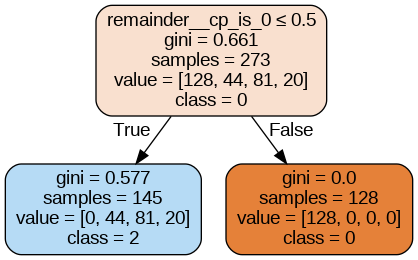

In [22]:
# Decision Tree plot

# Get the transformed feature names from the preprocessor
transformed_feature_names = list(ct.get_feature_names_out(X.columns))

# Export the decision tree to a DOT file

dot_data = export_graphviz(fitted_dt.named_steps['dt'],
                           feature_names = transformed_feature_names,
                           class_names = fitted_dt.named_steps['dt'].classes_.astype(str),
                           filled = True,
                           rounded = True,
                           special_characters = True,
                           out_file = None)

# Render the decision tree

graph = graphviz.Source(dot_data, format = 'png')
display(Image(graph.render(format='png', cleanup = True)))

Interpretation:
So the dominant class for the root was 0 with 128/273 samples being from that class.

If output is less than or equal to 0.5, then the class is 0.


Notes:
"gini=" : Known as Gini Impurity. It is a loss function that describes the likelihood of misclassification for a single sample. This metric can determine how to best split data at a given node in the tree.
"samples=" : total number of samples
"value=" : number of samples per class
"class=" : dominant class for the data at the node, dominant classes also represent the predicted outputs

In [23]:
# LDA naturally handles multi classification unlike Logistic

lda_pipeline = Pipeline(
    [("preprocessing", ct),
  ("lda", LinearDiscriminantAnalysis())]
)

lda_fitted = lda_pipeline.fit(X,y)
lda_preds = lda_fitted.predict(X)
lda_preds

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3,
       2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 3,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

It was best at distinguishing 3, 2, and 0.

In [3]:
ct2 = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown= 'ignore'), ['sex', 'restecg', 'output']),
                        ("standardize", StandardScaler(),['age','trtbps','chol','thalach'])], remainder = "passthrough")

In [ ]:
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)

X3 = ha.drop('cp_is_3', axis = 1)
y3 = ha['cp_is_3']

In [5]:
# Logistic Regression: cp 3, score: 1.0

l_pipeline3 = Pipeline(
    [("preprocessing", ct2),
     ("logistic", LogisticRegression(multi_class = 'ovr',penalty = 'elasticnet',solver = 'saga',l1_ratio = 1))
    ]
)

# Tuning

alphas3 = [0, 0.2, 0.4, 0.6, 0.8, 1]

alpha_values3 = {'logistic__l1_ratio':alphas3}

gscv3 = GridSearchCV(l_pipeline3, alpha_values3, cv = 5, scoring = 'f1_macro')
fitted_g3 = gscv3.fit(X3,y3)
results3 = pd.DataFrame(fitted_g3.cv_results_)
results3

logistic3 = pd.DataFrame(data = {"alpha": results3['param_logistic__l1_ratio'],"scores": results3['mean_test_score']})

logistic3.sort_values(by = 'scores', ascending = False)

# fitting

l_fitted3 = l_pipeline3.fit(X3,y3)

l_preds3 =l_fitted3.predict(X3)
l_preds3

# report score
f1_score(y3, l_preds3)



# # confusion matrix
# lcm = confusion_matrix(y3, l_preds3)
# lcm_df = pd.DataFrame(lcm, index=l_fitted3.classes_, columns=l_fitted3.classes_)
# lcm_df = lcm_df.unstack().reset_index()
# lcm_df.columns = ['Predicted', 'True', 'Count']
# lcm_df

# # Plot confusion matrix using plotnine
# (
#     ggplot(lcm_df, aes(x='Predicted', y='True', fill='Count')) +
#     geom_tile(color='white') +
#     geom_text(aes(label='Count'), size=10, color='black') +
#     labs(title='Confusion Matrix - log', x='Predicted', y='True') +
#     theme_minimal()
# )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

1.0

In [ ]:
# Target variable cp is 2 - L1 ratios were the same, score: 1.0
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)
ha

X2 = ha.drop('cp_is_2', axis = 1)
y2 = ha['cp_is_2']

# pipeline

l_pipeline2 = Pipeline(
    [("preprocessing", ct2),
     ("logistic", LogisticRegression(multi_class = 'ovr',penalty = 'elasticnet',solver = 'saga',l1_ratio = 1))
    ]
)

# Tuning

alphas2 = [0, 0.2, 0.4, 0.6, 0.8, 1]

alpha_values2 = {'logistic__l1_ratio':alphas2}

gscv2 = GridSearchCV(l_pipeline2, alpha_values2, cv = 5, scoring = 'f1_macro')
fitted_g2 = gscv2.fit(X2,y2)
results2 = pd.DataFrame(fitted_g2.cv_results_)
results2

logistic2 = pd.DataFrame(data = {"alpha": results2['param_logistic__l1_ratio'],"scores": results2['mean_test_score']})

logistic2.sort_values(by = 'scores', ascending = False)

# fitting

l_fitted2 = l_pipeline2.fit(X2,y2)

l_preds2 =l_fitted2.predict(X2)
l_preds2

# report score
f1_score(y2, l_preds2)


In [9]:
# Target variable cp is 1 - 1 best, score: 0.9767441860465117
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)
ha

X1 = ha.drop('cp_is_1', axis = 1)
y1 = ha['cp_is_1']


# pipeline

l_pipeline1 = Pipeline(
    [("preprocessing", ct2),
     ("logistic", LogisticRegression(multi_class = 'ovr',penalty = 'elasticnet',solver = 'saga',l1_ratio = 1))
    ]
)

# Tuning

alphas1 = [0, 0.2, 0.4, 0.6, 0.8, 1]

alpha_values1 = {'logistic__l1_ratio':alphas1}

gscv1 = GridSearchCV(l_pipeline1, alpha_values1, cv = 5, scoring = 'f1_macro')
fitted_g1 = gscv1.fit(X1,y1)
results1 = pd.DataFrame(fitted_g1.cv_results_)
results1

logistic1 = pd.DataFrame(data = {"alpha": results1['param_logistic__l1_ratio'],"scores": results1['mean_test_score']})

logistic1.sort_values(by = 'scores', ascending = False)

# fitting

l_fitted1 = l_pipeline1.fit(X1,y1)

l_preds1 =l_fitted1.predict(X1)
l_preds1

# report score
f1_score(y1, l_preds1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

0.9767441860465117

In [10]:
# Target variable cp is 0 - L1 ratios were the same, score: 1.0
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)
ha

X0 = ha.drop('cp_is_0', axis = 1)
y0 = ha['cp_is_0']

# pipeline

l_pipeline0 = Pipeline(
    [("preprocessing", ct2),
     ("logistic", LogisticRegression(multi_class = 'ovr',penalty = 'elasticnet',solver = 'saga',l1_ratio = 1))
    ]
)

# Tuning

alphas0 = [0, 0.2, 0.4, 0.6, 0.8, 1]

alpha_values0 = {'logistic__l1_ratio':alphas0}

gscv0 = GridSearchCV(l_pipeline0, alpha_values0, cv = 5, scoring = 'f1_macro')
fitted_g0 = gscv0.fit(X0,y0)
results0 = pd.DataFrame(fitted_g0.cv_results_)
results0

logistic0 = pd.DataFrame(data = {"alpha": results0['param_logistic__l1_ratio'],"scores": results0['mean_test_score']})

logistic0.sort_values(by = 'scores', ascending = False)


l_fitted0 = l_pipeline0.fit(X0,y0)

l_preds0 =l_fitted0.predict(X0)
l_preds0

# report score
f1_score(y0, l_preds0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

1.0

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

The OvO approach was best at distinguishing between category 0 & 2. We used roc_auc because this was binary classification not multi.

In [4]:

ct3 = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown= 'ignore'), ['sex', 'restecg', 'output']),
                        ("standardize", StandardScaler(),['age','trtbps','chol','thalach'])], remainder = "passthrough")

In [5]:
ha1 = ha[(ha['cp']==0) | (ha['cp']==1)]

Xha1 = ha1.drop('cp', axis =1)
yha1 = ha1['cp']

In [6]:
# Score: 0.7372159090909092
lovo1_pipeline = Pipeline(
    [('preprocessing', ct3),
     ('logistic', LogisticRegression(multi_class='multinomial',penalty='elasticnet',solver = 'saga', l1_ratio =1))
    ]
)

lovo1_fitted = lovo1_pipeline.fit(Xha1,yha1)
lovo1_pred = lovo1_fitted.predict(Xha1)

scores = cross_val_score(lovo1_pipeline, Xha1, yha1, cv = 5, scoring = 'roc_auc')
scores.mean()

roc_auc_score(yha1,lovo1_pred)



0.7372159090909092

In [7]:
# Score: 0.7730316742081447
ha2 = ha[(ha['cp']==0) | (ha['cp']==2)]

Xha2 = ha2.drop('cp', axis =1)
yha2 = ha2['cp']

In [9]:
lovo2_pipeline = Pipeline(
    [('preprocessing', ct3),
     ('logistic', LogisticRegression(penalty='elasticnet',solver = 'saga', l1_ratio =1))
    ]
)

lovo2_fitted = lovo2_pipeline.fit(Xha2,yha2)
lovo2_pred = lovo2_fitted.predict(Xha2)

scores2 = cross_val_score(lovo2_pipeline, Xha2, yha2, cv = 5, scoring = 'roc_auc')
scores2.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


0.7730316742081447

In [ ]:
ha3 = ha[(ha['cp']==0) | (ha['cp']==3)]

X3 = ha3.drop('cp', axis =1)
y3 = ha3['cp']
ha3

In [11]:
# Score: 0.7234615384615386
lovo3_pipeline = Pipeline(
    [('preprocessing', ct3),
     ('logistic', LogisticRegression(penalty='elasticnet',solver = 'saga', l1_ratio =1))
    ]
)

lovo3_fitted = lovo3_pipeline.fit(X3,y3)
lovo3_pred = lovo3_fitted.predict(X3)

scores3 = cross_val_score(lovo3_pipeline, X3, y3, cv = 5, scoring = 'roc_auc')
scores3.mean()

0.7234615384615386